# New LSTM Bergen PM2.5

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from kerastuner import HyperModel, RandomSearch
import matplotlib.pyplot as plt
from scipy import stats

# Load data
df = pd.read_excel("PM25Trondheim.xlsx")

# Extract features and target variable
X = df[["TV", "Tmean", "HDD", "VP", "WS", "WG", "meanRH", "SD", "PP"]]
Y = df["PM25"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(data, target, time_steps, forecast_days):
    sequences = []
    targets = []
    for i in range(len(data) - time_steps - forecast_days + 1):
        sequences.append(data[i:i + time_steps])
        targets.append(target[i + time_steps:i + time_steps + forecast_days])
    return np.array(sequences), np.array(targets)

def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

# List of different time steps to test
time_steps_list = [2, 3, 4, 5, 6, 7]
forecast_days_list = [7, 10]

# Dictionary to hold train and test data for each time step and forecast day
data_dict = {}

for time_steps in time_steps_list:
    for forecast_days in forecast_days_list:
        X_seq, y_seq = create_sequences(X_scaled, Y, time_steps, forecast_days)
        X_train_seq, X_temp_seq, y_train_seq, y_temp_seq = train_test_split(X_seq, y_seq, test_size=0.4, random_state=42)
        X_val_seq, X_test_seq, y_val_seq, y_test_seq = train_test_split(X_temp_seq, y_temp_seq, test_size=0.5, random_state=42)
        data_dict[(time_steps, forecast_days)] = (X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq)

class MyHyperModel(HyperModel):
    def __init__(self, input_shape, forecast_days):
        self.input_shape = input_shape
        self.forecast_days = forecast_days

    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=512, step=16),
                              activation='relu',
                              return_sequences=True,
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              input_shape=self.input_shape))
        model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.4, 0.6, 0.8])))

        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(layers.LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=16),
                                  activation='relu',
                                  return_sequences=True))
            model.add(layers.Dropout(rate=hp.Choice(f'dropout_rate_{i}', values=[0.2, 0.4, 0.6, 0.8])))

        model.add(layers.LSTM(units=hp.Int('units_last', min_value=32, max_value=512, step=16),
                              activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(layers.Dropout(rate=hp.Choice('dropout_rate_last', values=[0.2, 0.4, 0.6, 0.8])))

        model.add(layers.Dense(self.forecast_days))
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mse')
        return model

results = {}
history_dict = {}

for time_steps in time_steps_list:
    for forecast_days in forecast_days_list:
        X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq = data_dict[(time_steps, forecast_days)]
        input_shape = (time_steps, X_train_seq.shape[2])

        # Define and tune the model
        hypermodel = MyHyperModel(input_shape=input_shape, forecast_days=forecast_days)
        tuner = RandomSearch(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=2,
            directory=f'my_dir_{time_steps}_{forecast_days}',
            project_name='PM25_prediction')

        tuner.search(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq))
        
        # Get best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Build final model with best hyperparameters
        final_model = tuner.hypermodel.build(best_hps)
        
        # Train the model
        history = final_model.fit(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq), verbose=1)
        history_dict[(time_steps, forecast_days)] = history
        
        # Plot learning curves
        plot_learning_curves(history)
        
        # Evaluate the model
        y_pred = final_model.predict(X_test_seq)
        test_loss = final_model.evaluate(X_test_seq, y_test_seq, verbose=0)
        
        # Additional evaluation metrics
        test_mae = mean_absolute_error(y_test_seq, y_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
        
        results[(time_steps, forecast_days)] = {
            'loss': test_loss,
            'mae': test_mae,
            'rmse': test_rmse
        }

# Print results for LSTM models
print("LSTM Model Results:")
for (time_steps, forecast_days), metrics in results.items():
    print(f"Time steps: {time_steps}, Forecast days: {forecast_days}")
    print(f"Test Loss: {metrics['loss']}")
    print(f"Test MAE: {metrics['mae']}")
    print(f"Test RMSE: {metrics['rmse']}")
    print("")

# Train and evaluate a Linear Regression model
print("Linear Regression Model Results:")

# Flatten data for linear regression
X_flat = X_scaled[time_steps_list[0] - 1:]  # Use the data for the minimum time_steps
Y_flat = Y[time_steps_list[0] - 1:]
X_train_flat, X_temp_flat, y_train_flat, y_temp_flat = train_test_split(X_flat, Y_flat, test_size=0.4, random_state=42)
X_val_flat, X_test_flat, y_val_flat, y_test_flat = train_test_split(X_temp_flat, y_temp_flat, test_size=0.5, random_state=42)

# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train_flat)

# Predict and evaluate
y_pred_lin = lin_reg.predict(X_test_flat)
lin_test_mae = mean_absolute_error(y_test_flat, y_pred_lin)
lin_test_rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_lin))

print(f"Test MAE: {lin_test_mae}")
print(f"Test RMSE: {lin_test_rmse}")
print("")

# Feature importance analysis using permutation importance
print("Feature Importance Analysis:")
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_flat, Y_flat)
result = permutation_importance(model_rf, X_flat, Y_flat, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature: {X.columns[i]}, Importance: {result.importances_mean[i]}")

# Statistical hypothesis testing

# Extract the LSTM results for T-Test
lstm_losses = np.array([metrics['loss'] for metrics in results.values()])

# comparing two groups
group1_losses = lstm_losses[:len(lstm_losses)//2]
group2_losses = lstm_losses[len(lstm_losses)//2:]

# Perform independent T-Test
t_stat, p_value = stats.ttest_ind(group1_losses, group2_losses)
print("Independent T-Test Results")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

# Perform ANOVA
num_groups = min(len(lstm_losses), len(time_steps_list))
group_size = len(lstm_losses) // num_groups
remainder = len(lstm_losses) % num_groups

groups = []
start = 0
for i in range(num_groups):
    end = start + group_size + (1 if i < remainder else 0)
    groups.append(lstm_losses[start:end])
    start = end

# Ensure there are at least two groups for ANOVA
if len(groups) >= 2:
    f_stat, p_value_anova = stats.f_oneway(*groups)
    print("ANOVA Results")
    print("F-Statistic:", f_stat)
    print("P-Value:", p_value_anova)
else:
    print("Not enough groups for ANOVA")


Trial 8 Complete [00h 16m 57s]
val_loss: 1.1256479620933533

Best val_loss So Far: 0.8934838771820068
Total elapsed time: 1d 00h 58m 50s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
208               |368               |units
0.2               |0.6               |dropout_rate
3                 |3                 |num_layers
304               |224               |units_0
0.8               |0.4               |dropout_rate_0
96                |304               |units_last
0.4               |0.4               |dropout_rate_last
0.001             |0.001             |learning_rate
368               |368               |units_1
0.6               |0.8               |dropout_rate_1
512               |48                |units_2
0.6               |0.2               |dropout_rate_2
128               |256               |units_3
0.2               |0.2               |dropout_rate_3

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - loss: 1.3525 - val_loss: 1.133

69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 1.0437 - val_loss: 1.0646
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.9977 - val_loss: 1.0627
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.9442 - val_loss: 1.0619
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 1.0230 - val_loss: 1.0646
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.9848 - val_loss: 1.0627
Epoch 16/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 1.0247 - val_loss: 1.0620
Epoch 17/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 506ms/step - loss: 0.9470 - val_loss: 1.0667
Epoch 18/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 1.0297 - val_loss: 1.0687
Epoch 19/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 1.0323 - val_loss: 1.0657
Epoch 20/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.9973 - val_loss: 1.0473
Epoch 21/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 1.0652 - val_loss: 1.0606
Epoch 22/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - l

KeyboardInterrupt: 

In [ ]:

# Policy Recommendations
print("\nPolicy Recommendations:")

# If LSTM models perform better than Linear Regression (based on lower MAE and RMSE)
if np.mean([metrics['rmse'] for metrics in results.values()]) < lin_test_rmse:
    print("1. The LSTM models outperform the Linear Regression model in terms of prediction accuracy. Policies should consider using advanced models like LSTM for better air quality forecasting.")

# Based on feature importance, recommend policies targeting key features
important_features = [X.columns[i] for i in result.importances_mean.argsort()[::-1]]
print("2. Based on feature importance, focus on improving conditions related to the most important features:")
for feature in important_features[:5]:  # Top 5 features
    print(f"- {feature}: Implement measures to reduce or control the impact of {feature}.")

# General recommendations based on evaluation metrics
if np.mean([metrics['mae'] for metrics in results.values()]) < lin_test_mae:
    print("3. Consider implementing policies that address the factors contributing to PM2.5 emissions, as indicated by the features with high importance scores, to reduce overall pollution levels.")
else:
    print("4. Continue monitoring and refining models to achieve better predictive performance, which can guide more effective policy interventions.")



Reloading Tuner from my_dir_6_10\PM25_prediction\tuner0.json
Epoch 1/50


C:\Users\congc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.1108 - val_loss: 1.0194
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9902 - val_loss: 1.1182
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9165 - val_loss: 1.0216
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9289 - val_loss: 1.0414
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0582 - val_loss: 0.8941
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9680 - val_loss: 1.0566
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0349 - val_loss: 0.9286
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9098 - val_loss: 0.9179
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8994 - val_loss: 0.9380
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8223 - val_loss: 0.9305
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8509 - val_loss: 0.9541
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8629 - val_l

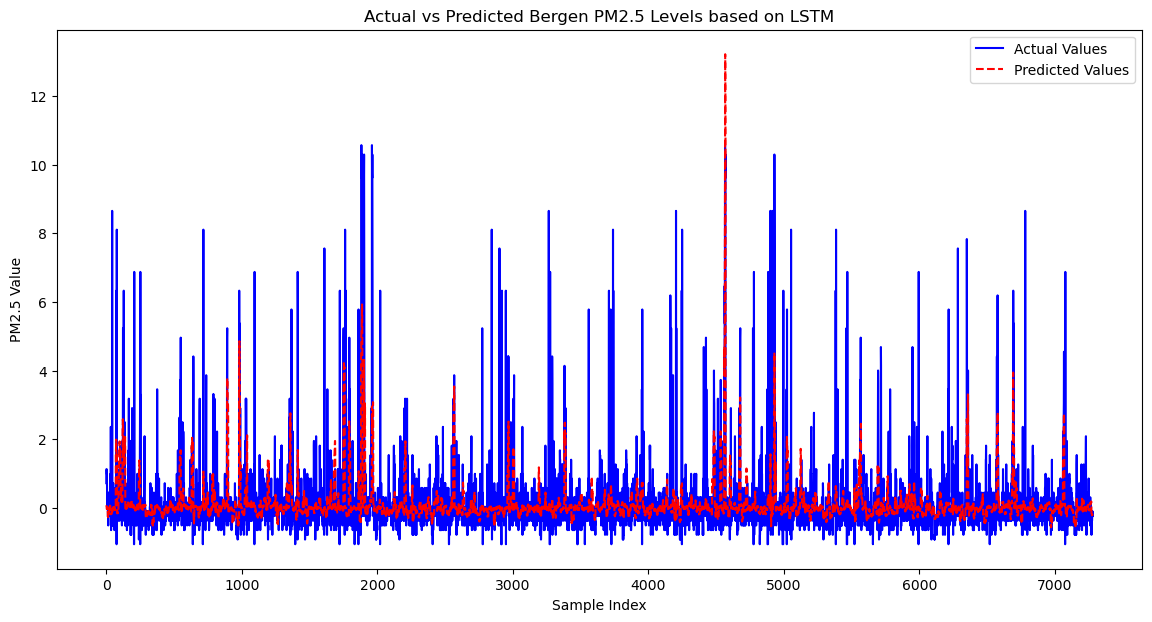

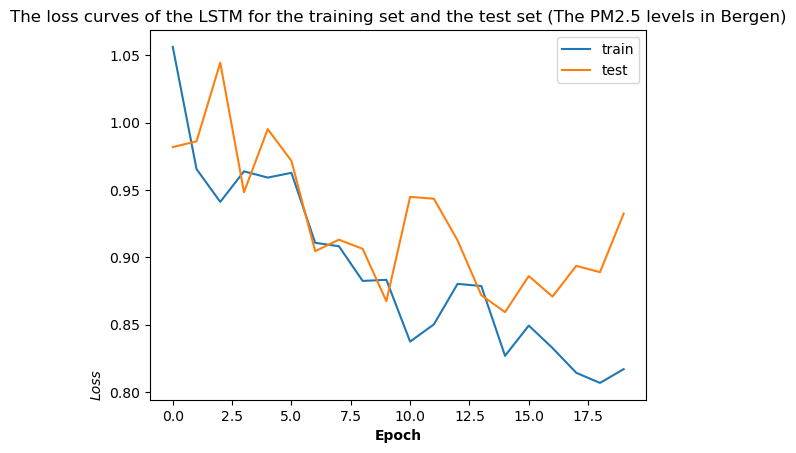

Best Hyperparameters:
units: 208
dropout_rate: 0.2
num_layers: 1
units_0: 48
dropout_rate_0: 0.4
units_last: 128
dropout_rate_last: 0.2
learning_rate: 0.001
units_1: 64
dropout_rate_1: 0.4
units_2: 192
dropout_rate_2: 0.4


In [6]:
# Plot predicted vs. actual values for the last LSTM model
import matplotlib.pyplot as plt

# Assuming the last (time_steps, forecast_days) tuple from your results
last_time_steps, last_forecast_days = list(results.keys())[-1]
X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq = data_dict[(last_time_steps, last_forecast_days)]

# Build the final model with best hyperparameters
hypermodel = MyHyperModel(input_shape=(last_time_steps, X_train_seq.shape[2]), forecast_days=last_forecast_days)
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=1,
    executions_per_trial=2,
    directory=f'my_dir_{last_time_steps}_{last_forecast_days}',
    project_name='PM25_prediction')

tuner.search(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq), verbose=1)

# Predict on the test set
y_pred = final_model.predict(X_test_seq)

# Plot predictions vs. actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_seq.flatten(), label='Actual Values', color='blue')
plt.plot(y_pred.flatten(), label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5 Value')
plt.title('Actual vs Predicted Bergen PM2.5 Levels based on LSTM')
plt.legend()
plt.show()
# Plot loss curves for the last LSTM model
 
history = history_dict[(last_time_steps, last_forecast_days)]
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('The loss curves of the LSTM for the training set and the test set (The PM2.5 levels in Bergen)')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', style='italic', loc='bottom')
plt.legend()
plt.show()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

In [5]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# List optimal hyperparameters
print("Optimal Hyperparameters:")
print(f"units: {best_hps.get('units')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")
print(f"num_layers: {best_hps.get('num_layers')}")

for i in range(best_hps.get('num_layers')):
    print(f"units_{i}: {best_hps.get(f'units_{i}')}")
    print(f"dropout_rate_{i}: {best_hps.get(f'dropout_rate_{i}')}")

print(f"units_last: {best_hps.get('units_last')}")
print(f"dropout_rate_last: {best_hps.get('dropout_rate_last')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")


Optimal Hyperparameters:
units: 208
dropout_rate: 0.2
num_layers: 1
units_0: 48
dropout_rate_0: 0.4
units_last: 128
dropout_rate_last: 0.2
learning_rate: 0.001


In [9]:
import sys
print(sys.version)


3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
